In [31]:
# Import PyTorch
import torch
from torch import nn

# Import torchvision 
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

# Import matplotlib for visualization
import matplotlib.pyplot as plt

# Check versions
# Note: your PyTorch version shouldn't be lower than 1.10.0 and torchvision version shouldn't be lower than 0.11
print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

PyTorch version: 2.0.1+cu117
torchvision version: 0.15.2+cu117


In [33]:
# Setup training data
train_data = datasets.FashionMNIST(
    root="data", # where to download data to?
    train=True, # get training data
    download=True, # download data if it doesn't exist on disk
    transform=ToTensor(), # images come as PIL format, we want to turn into Torch tensors
    target_transform=None # you can transform labels as well
)

# Setup testing data
test_data = datasets.FashionMNIST(
    root="data",
    train=False, # get test data
    download=True,
    transform=ToTensor()
)

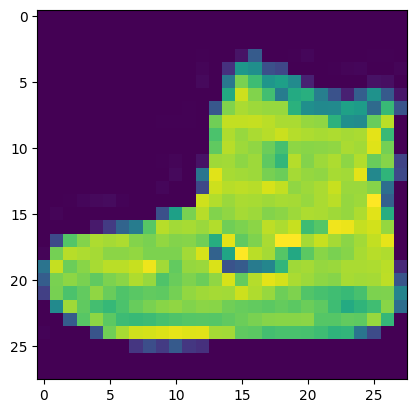

In [48]:
img, label = train_data[0]
plt.imshow(img.squeeze())

In [96]:
from torch.utils.data import DataLoader

# Setup the batch size hyperparameter
BATCH_SIZE = 1000

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(train_data, # dataset to turn into iterable
    batch_size=BATCH_SIZE, # how many samples per batch? 
    shuffle=True # shuffle data every epoch?
)

test_dataloader = DataLoader(test_data,
    batch_size=BATCH_SIZE,
    shuffle=False # don't necessarily have to shuffle the testing data
)

# Let's check out what we've created
print(f"Dataloaders: {train_dataloader, test_dataloader}") 
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x000000008EDFEF10>, <torch.utils.data.dataloader.DataLoader object at 0x000000008EDFE2E0>)
Length of train dataloader: 60 batches of 1000
Length of test dataloader: 10 batches of 1000


In [50]:
from torch import nn
class FashionMNISTModelV0(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # neural networks like their inputs in vector form
            nn.Linear(in_features=input_shape, out_features=hidden_units), # in_features = number of features in a data sample (784 pixels)
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )
    
    def forward(self, x):
        return self.layer_stack(x)

In [77]:
class TinyVGG(nn.Module):
    def __init__(self,
                img_size=28,
                in_channels=1,
                out_channels=10
                ):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels, 10, 3, 1, 0),
            nn.GELU(),

            nn.Conv2d(10, 10, 3, 1, 0),
            nn.GELU(),
            nn.MaxPool2d(2),

            nn.Conv2d(10, 10, 3, 1, 0),
            nn.GELU(),
            nn.MaxPool2d(2),
            nn.Flatten(),

            nn.Linear(250, 100),
            nn.GELU(),
            nn.Linear(100, out_channels),
            nn.GELU()
        )
    def forward(self, x):
        return self.layers(x)
Model = TinyVGG()
img = torch.randn((32,1, 28, 28))
Model.forward(img).shape

torch.Size([32, 10])

In [90]:
#model_0 = FashionMNISTModelV0(784, 100, 10)
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
model_0 = TinyVGG(in_channels=1)
model_0.to(device)
loss_fn = nn.CrossEntropyLoss() # this is also called "criterion"/"cost function" in some places
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)
def accuracy_fn(y_true, y_pred):
    num = 0
    for i in range(len(y_true)):
        num += (y_true[i] == y_pred[i])
    return 100.0*num/len(y_true)

In [97]:
# Set the seed and start the timer
torch.manual_seed(42)

# Set the number of epochs (we'll keep this small for faster training times)
epochs = 10

# Create training and testing loop
for epoch in range(epochs):
    print(f"Epoch: {epoch}\n-------")
    ### Training
    train_loss = 0
    # Add a loop to loop through training batches
    for batch, (X, y) in enumerate(train_dataloader):
        model_0.train() 
        X = X.to(device)
        y = y.to(device)
        # 1. Forward pass
        y_pred = model_0(X)

        # 2. Calculate loss (per batch)
        loss = loss_fn(y_pred, y)
        train_loss += loss # accumulatively add up the loss per epoch 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Print out how many samples have been seen
        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

    # Divide total train loss by length of train dataloader (average loss per batch per epoch)
    train_loss /= len(train_dataloader)
    
    ### Testing
    # Setup variables for accumulatively adding up loss and accuracy 
    test_loss, test_acc = 0, 0 
    model_0.eval()
    with torch.inference_mode():
        for X, y in test_dataloader:
            X = X.to(device)
            y = y.to(device)
            # 1. Forward pass
            test_pred = model_0(X)
           
            # 2. Calculate loss (accumatively)
            test_loss += loss_fn(test_pred, y) # accumulatively add up the loss per epoch

            # 3. Calculate accuracy (preds need to be same as y_true)
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))
        
        # Calculations on test metrics need to happen inside torch.inference_mode()
        # Divide total test loss by length of test dataloader (per batch)
        test_loss /= len(test_dataloader)

        # Divide total accuracy by length of test dataloader (per batch)
        test_acc /= len(test_dataloader)

    ## Print out what's happening
    print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")

Epoch: 0
-------
Looked at 0/60000 samples

Train loss: 0.17312 | Test loss: 0.27022, Test acc: 90.48%

Epoch: 1
-------
Looked at 0/60000 samples

Train loss: 0.16471 | Test loss: 0.27045, Test acc: 90.68%

Epoch: 2
-------
Looked at 0/60000 samples

Train loss: 0.16157 | Test loss: 0.27234, Test acc: 90.72%

Epoch: 3
-------
Looked at 0/60000 samples

Train loss: 0.15955 | Test loss: 0.27184, Test acc: 90.70%

Epoch: 4
-------
Looked at 0/60000 samples

Train loss: 0.15793 | Test loss: 0.27096, Test acc: 90.72%

Epoch: 5
-------
Looked at 0/60000 samples

Train loss: 0.15654 | Test loss: 0.27230, Test acc: 90.65%

Epoch: 6
-------
Looked at 0/60000 samples

Train loss: 0.15516 | Test loss: 0.27312, Test acc: 90.76%

Epoch: 7
-------
Looked at 0/60000 samples

Train loss: 0.15411 | Test loss: 0.27411, Test acc: 90.64%

Epoch: 8
-------
Looked at 0/60000 samples

Train loss: 0.15285 | Test loss: 0.27485, Test acc: 90.58%

Epoch: 9
-------
Looked at 0/60000 samples

Train loss: 0.15206 

In [98]:
from torchinfo import summary
summary(model_0, (1000, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1000, 10]                --
├─Sequential: 1-1                        [1000, 10]                --
│    └─Conv2d: 2-1                       [1000, 10, 26, 26]        100
│    └─GELU: 2-2                         [1000, 10, 26, 26]        --
│    └─Conv2d: 2-3                       [1000, 10, 24, 24]        910
│    └─GELU: 2-4                         [1000, 10, 24, 24]        --
│    └─MaxPool2d: 2-5                    [1000, 10, 12, 12]        --
│    └─Conv2d: 2-6                       [1000, 10, 10, 10]        910
│    └─GELU: 2-7                         [1000, 10, 10, 10]        --
│    └─MaxPool2d: 2-8                    [1000, 10, 5, 5]          --
│    └─Flatten: 2-9                      [1000, 250]               --
│    └─Linear: 2-10                      [1000, 100]               25,100
│    └─GELU: 2-11                        [1000, 100]               --
│    └─L

In [100]:
train_data.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [105]:
train_data[0][0].unsqueeze(dim=0).shape

torch.Size([1, 1, 28, 28])

In [119]:
import random
idx = random.randint(1, 1000)
idx

370

Coat
Coat


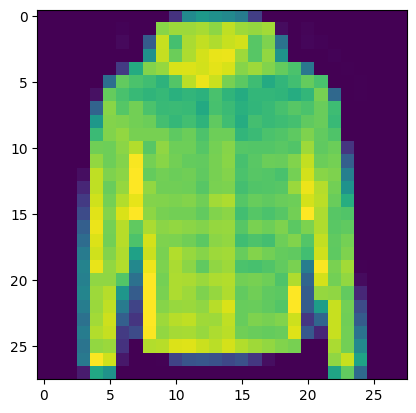

In [156]:
idx = random.randint(1, 1000)
with torch.inference_mode():
    plt.imshow(test_data[idx][0].squeeze())
    print(test_data.classes[ model_0(test_data[idx][0].unsqueeze(dim=0).to(device)).argmax(dim=1) ])
    print(test_data.classes[ test_data[idx][1] ])